# Dueling Network Architectures for Deep Reinforcement Learning

The authors (Wang et al., 2016) have implemented a network that calculates two separate estimators: one for the state value function and one for the state-dependant action advantage function. The paper differs from all other approaches, due to the fact the main focus lies in adjusting the neural network architecture instead of designing new, improved RL algorithms. We will be computing the value function, which is the agent's action independent estimate of the value of a given state and the state-dependent action advantages. Two streams share a standard convolution of a neural network that learns to understand the screen images. These two streams then get added together to produce the Q-network. In this dueling architecture, everything is the same as the DQN until the linear layers, where the output is split into two separate layers that are responsible for calculating the value and advantage function.

As mentioned before, this notebook is a replica of the work done in the paper (Wang et al., 2016) so we use the same network architecture as proposed. The neural network input consists of an 8 by 84 x 84 image produced by first preprocessing the observation returned by the OpenAI Atari environment. The first hidden layer convolves 32 filters of 8 x 8 with stride 4, followed by a rectified nonlinearity. The second hidden layer convolves 64 filters of 4 x 4, with side 2, again followed by rectified nonlinearity. This is followed by a third convolutional layer that convolves 64 filters of 3 x 3 with stride 1 followed by a rectifier. Afterward, the output is split into two separate layers responsible for calculating the state value function and state-dependant action advantage function.

We test our algorithms using the **Atari 2600 Pong** environment, where the goal is to maximize the score of the Pong game. In this environment, the observation is a two-dimensional array of three-element tuples (RGB). The shape of the array is (210, 160, 3). Each action is repeated four times on every four skipped frames. 
 
**References:**
- https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
- https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/tree/master/DuelingDDQN
- https://gym.openai.com/envs/Pong-v0/

## Import Libraries

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

import gym
import random
import numpy as np

import collections 
import cv2

from ipynb.fs.full.Plotting import *
import matplotlib.pyplot as plt

In [2]:
random.seed(2021)

## Image Preprocessing

In [3]:
# Derives from: Gym.Wrapper.
# Repeating actions over k'th skipped frames and taking max off the previous two frames to overcome flikkering. 

class RepeatAction(gym.Wrapper):
    def __init__(self, env, repeat, clip_reward):
        super(RepeatAction, self).__init__(env)
        
        self.repeat = repeat
        self.clip_reward = clip_reward
        
        self.shape = env.observation_space.low.shape
        self.frame_buffer = np.zeros_like((2, self.shape))

    def step(self, action):
        done = False
        score = 0.0

        # Repeat actions in the environment.
        for i in range(self.repeat):
            observation, reward, done, info = self.env.step(action)
            
            # Clip reward.
            if self.clip_reward:
                reward = np.clip(np.array([reward]), -1, 1)[0]  
            score += reward
            self.frame_buffer[i % 2] = observation
            
            if done:
                break

        max_frame = np.maximum(self.frame_buffer[0], self.frame_buffer[1]) # Return max frame.
        
        return max_frame, score, done, info

    def reset(self):
        observation = self.env.reset()
        self.frame_buffer = np.zeros_like((2,self.shape))
        self.frame_buffer[0] = observation

        return observation

# Derives from: Gym.ObservationWrapper.
# Reshape frame and convert to grayscale.

class PreprocessFrame(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super(PreprocessFrame, self).__init__(env)
        
        self.shape = (shape[2], shape[0], shape[1]) # PyTorch expects image channels first.
        self.observation_space = gym.spaces.Box(low = 0.0, high = 1.0, shape = self.shape, dtype = np.float32)

    def observation(self, observation):
        gray_frame = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY) # Convert to grayscale.
        resized_frame = cv2.resize(gray_frame, self.shape[1:], interpolation = cv2.INTER_AREA) # Resize frame.
        new_observation = np.array(resized_frame, dtype = np.uint8).reshape(self.shape) # Convert type.
        new_observation = new_observation / 255.0 # RGB ranges from 0 to 255, observation space ranges from 0 to 1.

        return new_observation

# Derives from: Gym.ObservationWrapper.
# Stack frames.

class StackFrames(gym.ObservationWrapper):
    def __init__(self, env, repeat):
        super(StackFrames, self).__init__(env)
        
        self.stack = collections.deque(maxlen = repeat)
        self.observation_space = gym.spaces.Box(env.observation_space.low.repeat(repeat, axis = 0),
                                                env.observation_space.high.repeat(repeat, axis = 0),
                                                dtype = np.float32)
        
    def reset(self):
        observation = self.env.reset()
        self.stack.clear()

        for _ in range(self.stack.maxlen):
            self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

    def observation(self, observation):
        self.stack.append(observation)

        return np.array(self.stack).reshape(self.observation_space.low.shape)

In [4]:
def make_env(env_name, shape = (84, 84, 1), repeat = 4, clip_rewards = False):
    env = gym.make(env_name)
    env = RepeatAction(env, repeat, clip_rewards)
    env = PreprocessFrame(env, shape)
    env = StackFrames(env, repeat)

    return env

## Replay Memory

In [5]:
class ReplayMemory():
    def __init__(self, observation_space, capacity):
        
        self.observation_space = observation_space 
        self.capacity = capacity
        self.replay_counter = 0
        
        self.observation_memory = np.zeros((self.capacity, *self.observation_space), dtype = np.float32)
        self.action_memory = np.zeros(self.capacity, dtype = np.int64)
        self.reward_memory = np.zeros(self.capacity, dtype = np.float32)
        self.next_observation_memory = np.zeros((self.capacity, *self.observation_space), dtype = np.float32)
        self.terminal_memory = np.zeros(self.capacity, dtype = np.bool)

    def store_experience(self, observation, action, reward, next_observation, done):
        index = self.replay_counter % self.capacity
        self.observation_memory[index] = observation
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_observation_memory[index] = next_observation
        self.terminal_memory[index] = done
        self.replay_counter += 1

    def sample_memory(self, batch_size):
        max_mem = min(self.replay_counter, self.capacity)
        batch = np.random.choice(max_mem, batch_size, replace = False)

        observations = self.observation_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_observations = self.next_observation_memory[batch]
        terminals = self.terminal_memory[batch]

        return observations, actions, rewards, next_observations, terminals

## Dueling Double Deep Q-network

In [6]:
class DuelingDeepQNetwork(nn.Module):
    def __init__(self, observation_space, action_space, learning_rate):
        super(DuelingDeepQNetwork, self).__init__()
        
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate

        self.conv1 = nn.Conv2d(self.observation_space[0], 32, 8, stride = 4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride = 2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride = 1)

        self.fc_observation_space = self.calculate_convolutional_output(self.observation_space)

        self.fc1 = nn.Linear(self.fc_observation_space, 512)
        self.V = nn.Linear(512, 1)
        self.A = nn.Linear(512, self.action_space)

        self.optimizer = optim.RMSprop(self.parameters(), lr = self.learning_rate)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.loss = nn.MSELoss()
        self.to(self.device)

    def calculate_convolutional_output(self, observation_space):
        state = T.zeros(1, *observation_space)
        dims = self.conv1(state)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.size()))

    def forward(self, observation):
        conv1 = F.relu(self.conv1(observation))
        conv2 = F.relu(self.conv2(conv1))
        conv3 = F.relu(self.conv3(conv2))
        conv_state = conv3.view(conv3.size()[0], -1) # Conv3 shape is BS x n_filters x H x W.
        flat1 = F.relu(self.fc1(conv_state)) # Conv_state shape is BS x (n_filters * H * W).
        V = self.V(flat1)
        A = self.A(flat1)
        
        return V, A

## Reinforcement Learning Agent

In [7]:
class Agent():
    def __init__(self, observation_space, action_space, learning_rate = 0.0001, discount_rate = 0.99, exploration_rate = 1.0,
                 max_exploration_rate = 1, min_exploration_rate = 0.1, exploration_decay_rate = 0.01,
                 batch_size = 32, replace = 1000, capacity = 50000):
        
        self.episode = 0
        self.learn_counter = 0 
        
        self.observation_space = observation_space
        self.action_space = action_space
        
        self.learning_rate = learning_rate
        self.discount_rate = discount_rate
        
        self.exploration_rate = exploration_rate
        self.max_exploration_rate = max_exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        
        self.batch_size = batch_size
        self.replace = replace
        self.capacity = capacity
        
        self.replay_memory = ReplayMemory(self.observation_space, self.capacity)
        self.policy_network = DuelingDeepQNetwork(self.observation_space, self.action_space, self.learning_rate)
        self.target_network = DuelingDeepQNetwork(self.observation_space, self.action_space, self.learning_rate)
        
    def choice_action(self, observation):
        exploration_rate_threshold = np.random.random()
        if exploration_rate_threshold > self.exploration_rate:
            observation = T.tensor([observation], dtype = T.float).to(self.policy_network.device)
            _, advantage = self.policy_network.forward(observation)
            action = T.argmax(advantage).item() # Best Q-value for action in state.
        else:
            action = np.random.choice(self.action_space) # Random Action.
            
        return action
    
    def store_experience(self, observation, action, reward, next_observation, done):
        self.replay_memory.store_experience(observation, action, reward, next_observation, done)

    def sample_memory(self):
        observations, actions, rewards, next_observations, terminals = self.replay_memory.sample_memory(self.batch_size)
        
        return observations, actions, rewards, next_observations, terminals

    def replace_target_network(self):
        if self.learn_counter % self.replace == 0:
            self.target_network.load_state_dict(self.policy_network.state_dict())
            
    def decrease_exploration_rate(self):
        self.exploration_rate = self.min_exploration_rate + \
            (self.max_exploration_rate - self.min_exploration_rate) * np.exp(- self.exploration_decay_rate * self.episode)
        self.episode += 1

    def learn(self):
        if self.replay_memory.replay_counter < self.batch_size:
            return
        
        # Increment learn counter.
        self.learn_counter += 1
        
        # Set gradient to zero.
        self.policy_network.optimizer.zero_grad()
        
        # Copy policy network to target network after.
        self.replace_target_network()

        # Sample from replay memory.
        observations, actions, rewards, next_observations, terminals = self.sample_memory()
        
        # Convert to tensors.
        observations = T.tensor(observations).to(self.policy_network.device)
        actions = T.tensor(actions).to(self.policy_network.device)
        rewards = T.tensor(rewards).to(self.policy_network.device)
        next_observations = T.tensor(next_observations).to(self.policy_network.device)
        terminals = T.tensor(terminals).to(self.policy_network.device)
        
        # Calculate loss using Bellman equation.
        indices = np.arange(self.batch_size)
        value_function, action_advantage = self.policy_network.forward(observations)
        next_value_function, next_action_advantage = self.target_network.forward(next_observations)
        q_pred = T.add(value_function, (action_advantage - action_advantage.mean(dim = 1, keepdim = True)))[indices, actions]
        q_next = T.add(next_value_function, (next_action_advantage - next_action_advantage.mean(dim = 1, keepdim = True))).max(dim = 1)[0]
        q_next[terminals] = 0.0
        q_target = rewards + self.discount_rate * q_next
        loss = self.policy_network.loss(q_target, q_pred).to(self.policy_network.device)
        
        # Optimizer in action.
        loss.backward()
        self.policy_network.optimizer.step()

## Main Program

In [8]:
step = 0
episodes = 500

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


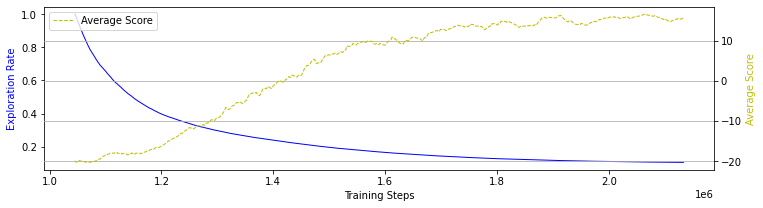

In [10]:
env = make_env('PongNoFrameskip-v4')

observation_space = env.observation_space.shape
action_space = env.action_space.n
agent = Agent(observation_space, action_space)

scores, exploration_rate_history, steps = [], [], []

for i in range(episodes):
    observation = env.reset()
    done = False
    score = 0.0
    
    while not done:
        action = agent.choice_action(observation)
        next_observation, reward, done, _ = env.step(action)
        agent.store_experience(observation, action, reward, next_observation, done)
        agent.learn()
        observation = next_observation
        score += reward
        step += 1
    
    scores.append(score)
    steps.append(step)
    exploration_rate_history.append(agent.exploration_rate)
    agent.decrease_exploration_rate()

plot_learning_curve(steps, scores, exploration_rate_history)